# Building a linear regression model using LASSO regression

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import utils
from sklearn.feature_extraction.text import TfidfVectorizer

# para conseguir repetir o experimento 
seed = 50
np.random.seed(seed)

In [20]:
def vectorization(features_list):

    data = features_list

    def tokenize(formula):

        tokens = [formula[i:i+2] for i in range(0, len(formula)-1, 2)]
        return tokens

    vectorizer = TfidfVectorizer(tokenizer=tokenize, lowercase=False)

    tfidf_matrix = vectorizer.fit_transform(data)

    df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    return df


Note that we have NaN values in our datasets. These values will be a problem for our model. We can remove these values using some useful methods (source: https://saturncloud.io/blog/python-pandas-how-to-remove-nan-and-inf-values/#:~:text=Using%20dropna(),one%20NaN%20or%20%2Dinf%20value.). Since we don't know exactly what these features are describing, we'll drop the rows that contains columns with NaN values

In [21]:
df = pd.read_csv('AB2_formation_energy_materials_spacegroup.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df.head(5)
df = df.dropna(axis=1)

## Data Spliting

We can evaluate the distribution of the train set using a histogram. Remembering that the target is "hform" column, we can plot the distribution for this one

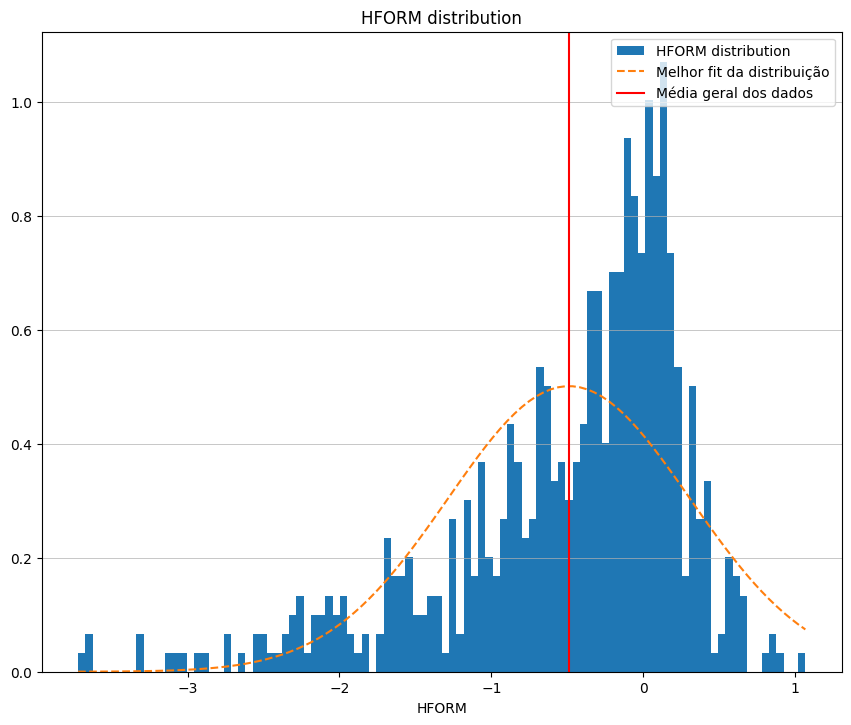

In [22]:
utils.histogram('fixed_bins_size', df['hform'], 'HFORM', 'upper right', 100, 'HFORM distribution')

## Vectorizing

In [23]:
features = df.drop(columns=['hform', 'Material', 'Space Group'])

In [24]:
material_vectorization = vectorization(df['Material'].tolist())
space_vectorization = vectorization(df['Space Group'].tolist())
features = pd.concat([features, material_vectorization, space_vectorization], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


We should spliting our data to separate the df in two sets: train set e test set. Since we have a different dictionary to our features and target, we'll do the following

In [25]:
from sklearn.model_selection import train_test_split


features_train, features_test = train_test_split(features, test_size = 0.2, random_state = 2)
target_train, target_test = train_test_split(df['hform'], test_size = 0.2, random_state = 2)


## Lasso Regression

The word “LASSO” stands for Least Absolute Shrinkage and Selection Operator. It is a statistical formula for the regularisation of data models and feature selection. Regularization is an important concept that is used to avoid overfitting of the data, especially when the trained and test data are much varying. Regularization is implemented by adding a “penalty” term to the best fit derived from the trained data, to achieve a lesser variance with the tested data and also restricts the influence of predictor variables over the output variable by compressing their coefficients.

In regularization, what we do is normally we keep the same number of features but reduce the magnitude of the coefficients. We can reduce the magnitude of the coefficients by using different types of regression techniques which uses regularization to overcome this problem. 

Therefore, LASSO regression, also known as L1 regularization, is a popular technique used in statistical modeling and machine learning to estimate the relationships between variables and make predictions.

In [26]:
from sklearn import metrics
from sklearn import linear_model

model_lasso = linear_model.Lasso(alpha=1,max_iter=100000) # least square minimum
model_lasso.fit(features_train,target_train)

y_pred_train = model_lasso.predict(features_train)
train_error  = metrics.mean_squared_error(target_train, y_pred_train, squared=True)


y_pred_test=model_lasso.predict(features_test)
test_error=metrics.mean_squared_error(target_test, y_pred_test, squared=True)

print('Train error (MSE): ', train_error)
print('Test error (MSE):  ', test_error)


Train error (MSE):  0.41277060192118925
Test error (MSE):   0.4451950457743835


In [27]:
print('Lasso coef: ', model_lasso.coef_)
print('Max of the Lasso coef: ', np.max(np.abs(model_lasso.coef_)))
print('Min of the Lasso coef: ', np.min(np.abs(model_lasso.coef_)))
print('Index of the max of the lasso coef: ', np.argmax(model_lasso.coef_))
print('Index of the min of the lasso coef: ', np.argmin(np.abs(model_lasso.coef_)))

Lasso coef:  [ 0.00463863  0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.00551774  0.00645807
 -0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.00942023  0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.

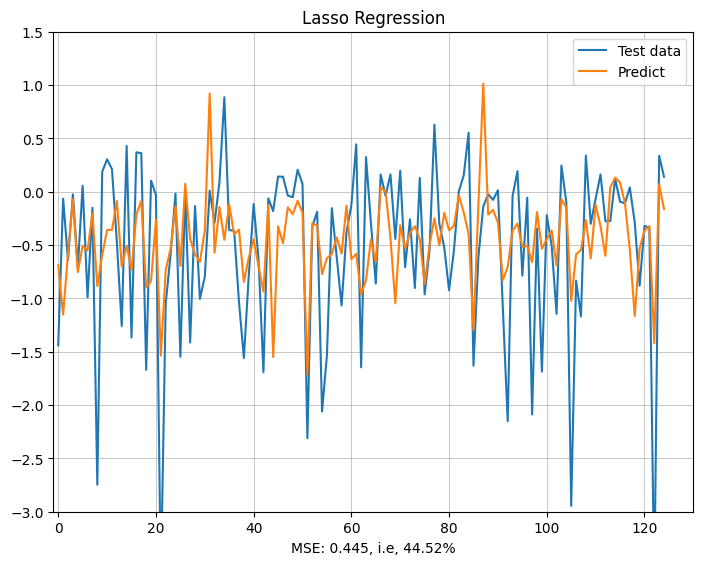

In [41]:
fig = plt.figure(figsize=(8,6))

axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(target_test.squeeze().reset_index(drop=True), ls='-', label="Test data")
axes.plot(y_pred_test, ls='-', label="Predict")
axes.set_xlim(-1, 130)
axes.set_ylim(-3, 1.5)
axes.set_title(f'Lasso Regression')
axes.set_xlabel(f'MSE: {test_error:.3f}, i.e, {test_error*100.0:.2f}%')

axes.legend(loc='upper right')

plt.grid(linestyle='-', linewidth=0.5)